# Sioux Falls Attempt

In [1]:
import networkx as nx
import scipy.integrate as integrate 
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from scipy.misc import derivative
import TransportationNetworks as tn


In [2]:
path = "./SiouxFalls/"
link_file = '{}SiouxFalls_net.tntp'.format(path)
trip_file = '{}SiouxFalls_trips.tntp'.format(path)
node_file = '{}SiouxFalls_node.tntp'.format(path)

### Latency Function

In [3]:
def latency_func(t0, x, c, alpha, beta):
    # Input: t0 = free flow time, x = traffic flow, c = road capacity, α, β = pre-determined parameters
    
    # Output: t_x = travel time for a vehicle on link x
    
    t_x = t0*(1+alpha*(x/c)**beta)
    return t_x

### Calculating Objective Function Value

In [4]:
def calculate_optimum(theta, network, SO):
    z = 0
    for linkKey, linkVal in network.items():
        t0 = linkVal['t0']
        c = linkVal['capa']
        beta = linkVal['beta']
        alpha = linkVal['alpha']
        aux = linkVal['auxiliary'][-1]
        flow = linkVal['flow'][-1]
        
        if SO == False:
            z += integrate.quad(lambda x: latency_func(t0, x, c, alpha, beta), 0, flow+theta*(aux-flow))[0]
        elif SO == True:
            z += list(map(lambda x : x * latency_func(t0, x, c, alpha, beta), [flow+theta*(aux-flow)]))[0]
    return z

### Finding Optimal Theta

In [6]:
def lineSearch(network, SO):
    theta = minimize_scalar(lambda x: calculate_optimum(x, network, SO), bounds = (0,1), method = 'Bounded')
    return theta.x

## Frank Wolfe Algorithm

### Initialisation

In [5]:
# define output variables, network and fwResult
network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
           'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
           'auxiliary':[], 'cost':[]} for (u, v, d) in siouxFalls.graph.edges(data=True)}

fwResult = {'theta':[], 'z':[]}

# initial all-or-nothing assignment and update link travel time(cost)
siouxFalls.all_or_nothing_assignment()
siouxFalls.update_linkcost()

for linkKey, linkVal in network.items():
    linkVal['cost'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['weight'])
    linkVal['auxiliary'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol)
    linkVal['flow'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol)

### Algorithm

In [12]:
iterNum=0
iteration = True
while iteration:
    iterNum += 1
    siouxFalls.all_or_nothing_assignment()
    siouxFalls.update_linkcost()
    
    # set auxiliary flow using updated link flow
    for linkKey, linkVal in network.items():
        linkVal['auxiliary'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol)
        
    # getting optimal move size (theta)
    theta = lineSearch(network, SO)
    fwResult['theta'].append(theta)
    
    # set link flow (move) based on the theta, auxiliary flow, and link flow of previous iteration
    for linkKey, linkVal in network.items():
        aux = linkVal['auxiliary'][-1]
        flow = linkVal['flow'][-1]
        linkVal['flow'].append(flow + theta*(aux-flow))
        
        siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
        siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)
        
    # update link travel time
    siouxFalls.update_linkcost()
    
    # calculate objective function value
    z=0
    for linkKey, linkVal in network.items():
        linkVal['cost'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['weight'])
        totalcost = siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].get_objective_function()
        z+=totalcost
        
    fwResult['z'].append(z)        
        
    # convergence test
    if iterNum == 1:
        iteration = True
    else:
        if abs(fwResult['z'][-2] - fwResult['z'][-1]) <= 0.001 or iterNum==3000:
            iteration = False

In [13]:
for (u, v, d) in siouxFalls.graph.edges(data=True):
    print(u, ' -> ', v, ': ', d['object'].vol)

1  ->  2 :  4494.541769784984
1  ->  3 :  8118.778958294006
2  ->  1 :  4519.2217979362385
2  ->  6 :  5967.415424045609
3  ->  1 :  8094.098930142726
3  ->  4 :  14011.734532547742
3  ->  12 :  10027.635980519834
6  ->  2 :  5992.095452196839
6  ->  5 :  8806.410890329136
6  ->  8 :  12492.07533894963
4  ->  3 :  14035.300255016178
4  ->  5 :  18010.561177852334
4  ->  11 :  5203.138655249963
12  ->  3 :  9979.390229900207
12  ->  11 :  8404.306735841823
12  ->  13 :  12293.49958218216
5  ->  4 :  18034.52551780119
5  ->  6 :  8797.189586981583
5  ->  9 :  15783.99628930851
11  ->  4 :  5302.740037769514
11  ->  10 :  17603.652145817512
11  ->  12 :  8365.259304266572
11  ->  14 :  9776.84654332046
9  ->  5 :  15798.739325909786
9  ->  8 :  6837.003588250082
9  ->  10 :  21745.9882349121
8  ->  6 :  12525.976670448466
8  ->  7 :  12041.69663131243
8  ->  9 :  6881.813917212696
8  ->  16 :  8387.782258834914
7  ->  8 :  12102.268632545403
7  ->  18 :  15797.411851008834
18  ->  7 :  15

In [17]:
siouxFalls.graph.edges(data=True)

OutEdgeDataView([('1', '2', {'object': <TransportationNetworks.Link object at 0x111370f40>, 'time': 6.0, 'pos_fnode': (-685.4351091846027, -4921.613640570747), 'pos_tnode': (-685.3759400746027, -4921.6206555107465), 'weight': 6.000816153183985}), ('1', '3', {'object': <TransportationNetworks.Link object at 0x111370ca0>, 'time': 4.0, 'pos_fnode': (-5073.212627765639, 528.4044843879101), 'pos_tnode': (-5073.216511435639, 528.3646180679101), 'weight': 4.008689461548967}), ('2', '1', {'object': <TransportationNetworks.Link object at 0x1113712d0>, 'time': 6.0, 'pos_fnode': (491.9534388146027, 5008.832281470747), 'pos_tnode': (491.8942697046027, 5008.839296410747), 'weight': 6.000834227729821}), ('2', '6', {'object': <TransportationNetworks.Link object at 0x111371090>, 'time': 5.0, 'pos_fnode': (-5095.547938810264, 151.45647316792534), 'pos_tnode': (-5095.548332070264, 151.43824571792533), 'weight': 6.573681616261519}), ('3', '1', {'object': <TransportationNetworks.Link object at 0x111370be0

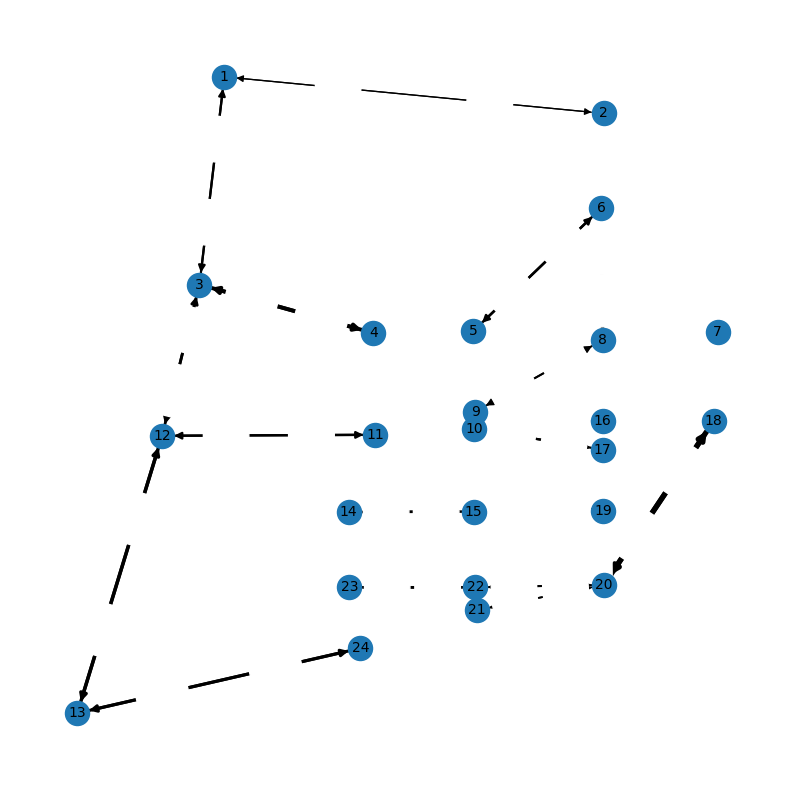

In [15]:
edgewidth = [d['object'].vol/5000 for (u, v, d) in siouxFalls.graph.edges(data=True)]

if node_file != None:
    plt.figure(num = 1, figsize=(10,10))
    plt.axis('off')
    
    pos = nx.get_node_attributes(siouxFalls.graph, "pos")

    # Draw edges
    nx.draw_networkx_edges(siouxFalls.graph, pos, width=edgewidth)

    # Draw edge labels
    nx.draw_networkx_edge_labels(siouxFalls.graph, pos,
                                 edge_labels={(u, v): round(d["object"].vol,0) for u, v, d in siouxFalls.graph.edges(data=True)},
                                 font_size=8, label_pos=0.3, alpha=0.)

    # Draw nodes
    nx.draw_networkx_nodes(siouxFalls.graph, pos)

    # Draw node labels
    nx.draw_networkx_labels(siouxFalls.graph, pos, font_size=10)
    
    plt.show()

In [7]:
def frank_wolfe(location, SO):
    # Input: location = road traffic network, SO = # True - System optimum, False - User equilibrium
    
    path = "./{}/".format(location)
    link_file = path + '{}_net.tntp'.format(location)
    trip_file = path + '{}_trips.tntp'.format(location)
    node_file = path + '{}_node.tntp'.format(location)
    

    location_net = tn.Network(link_file, trip_file, node_file, SO)

    # define output variables, network and fwResult
    network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
               'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
               'auxiliary':[], 'cost':[]} for (u, v, d) in location_net.graph.edges(data=True)}

    fwResult = {'theta':[], 'z':[]}

    # initial all-or-nothing assignment and update link travel time(cost)
    location_net.all_or_nothing_assignment()
    location_net.update_linkcost()

    for linkKey, linkVal in network.items():
        linkVal['cost'].append(location_net.graph[linkKey[0]][linkKey[1]]['weight'])
        linkVal['auxiliary'].append(location_net.graph[linkKey[0]][linkKey[1]]['object'].vol)
        linkVal['flow'].append(location_net.graph[linkKey[0]][linkKey[1]]['object'].vol)

    iterNum=0
    iteration = True
    while iteration:
        iterNum += 1
        location_net.all_or_nothing_assignment()
        location_net.update_linkcost()

        # set auxiliary flow using updated link flow
        for linkKey, linkVal in network.items():
            linkVal['auxiliary'].append(location_net.graph[linkKey[0]][linkKey[1]]['object'].vol)

        # getting optimal move size (theta)
        theta = lineSearch(network, SO)
        fwResult['theta'].append(theta)

        # set link flow (move) based on the theta, auxiliary flow, and link flow of previous iteration
        for linkKey, linkVal in network.items():
            aux = linkVal['auxiliary'][-1]
            flow = linkVal['flow'][-1]
            linkVal['flow'].append(flow + theta*(aux-flow))

            location_net.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
            location_net.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)

        # update link travel time
        location_net.update_linkcost()

        # calculate objective function value
        z=0
        for linkKey, linkVal in network.items():
            linkVal['cost'].append(location_net.graph[linkKey[0]][linkKey[1]]['weight'])
            totalcost = location_net.graph[linkKey[0]][linkKey[1]]['object'].get_objective_function()
            z+=totalcost

        fwResult['z'].append(z)        

        # convergence test
        if iterNum == 1:
            iteration = True
        else:
            if abs(fwResult['z'][-2] - fwResult['z'][-1]) <= 0.001 or iterNum==3000:
                iteration = False
                
    return location_net, fwResult

In [8]:
siouxfalls_SO, SF_fw_SO = frank_wolfe(location = "SiouxFalls", SO = True)
siouxfalls_UE, SF_fw_UE = frank_wolfe(location = "SiouxFalls", SO = False)

In [9]:
def update_travel_times_and_costs_outside(network):
    for (u, v, d) in network.graph.edges(data=True):
        link_obj = d['object']
        current_flow = link_obj.flow  # Assuming this gives the final flow
        t0 = link_obj.t0
        c = link_obj.capacity
        alpha = link_obj.alpha
        beta = link_obj.beta
        # Calculate the travel time with the final flow
        travel_time = latency_func(t0, current_flow, c, alpha, beta)
        # Optionally calculate total cost (travel time * flow)
        total_cost = travel_time * current_flow
        # Update the network with the new travel time and total cost
        network.graph[u][v]['travel_time'] = travel_time
        network.graph[u][v]['total_cost'] = total_cost
    return network


In [10]:
# Update travel times and costs outside of the Frank-Wolfe function
update_travel_times_and_costs_outside(siouxfalls_SO)
update_travel_times_and_costs_outside(siouxfalls_UE)


In [12]:
def PoA(network_ne, network_so):
    total_cost_ne = sum(d['total_cost'] for u, v, d in network_ne.graph.edges(data=True))
    total_cost_so = sum(d['total_cost'] for u, v, d in network_so.graph.edges(data=True))
    
    if total_cost_so == 0:
        raise ValueError("The total cost for the system optimum cannot be zero.")
    
    poa = total_cost_ne / total_cost_so 
    return poa

poa = PoA(siouxfalls_UE, siouxfalls_SO)
print(f"The Price of Anarchy (PoA) is: {poa}")

The Price of Anarchy (PoA) is: 0.9920148679419287


In [13]:
berlin_SO, b_fw_SO = frank_wolfe(location = "berlin", SO = True)
berlin_UE, b_fw_UE = frank_wolfe(location = "berlin", SO = False)

['1   ', '0.9743120000 ', ' ', '1.8510700000 ', ' ', '; \n']
['2   ', '1.1557500000 ', ' ', '1.9349500000 ', ' ', '; \n']
['3   ', '1.2881100000 ', ' ', '1.1936600000 ', ' ', '; \n']
['4   ', '1.5453500000 ', ' ', '1.1023200000 ', ' ', '; \n']
['5   ', '1.9144500000 ', ' ', '0.7077440000 ', ' ', '; \n']
['6   ', '0.6617620000 ', ' ', '0.6499560000 ', ' ', '; \n']
['7   ', '0.6083240000 ', ' ', '1.0619300000 ', ' ', '; \n']
['8   ', '1.4826000000 ', ' ', '0.3069580000 ', ' ', '; \n']
['9   ', '1.3763400000 ', ' ', '1.5664800000 ', ' ', '; \n']
['10  ', '1.7821000000 ', ' ', '1.0358300000 ', ' ', '; \n']
['11  ', '2.0480400000 ', ' ', '0.9948180000 ', ' ', '; \n']
['12  ', '1.4384800000 ', ' ', '0.8121340000 ', ' ', '; \n']
['13  ', '1.6801900000 ', ' ', '0.8171050000 ', ' ', '; \n']
['14  ', '0.2485490000 ', ' ', '1.0519800000 ', ' ', '; \n']
['15  ', '0.3262210000 ', ' ', '1.3695100000 ', ' ', '; \n']
['16  ', '1.6621700000 ', ' ', '0.2802390000 ', ' ', '; \n']
['17  ', '0.8239400000 '

['1   ', '0.9743120000 ', ' ', '1.8510700000 ', ' ', '; \n']
['2   ', '1.1557500000 ', ' ', '1.9349500000 ', ' ', '; \n']
['3   ', '1.2881100000 ', ' ', '1.1936600000 ', ' ', '; \n']
['4   ', '1.5453500000 ', ' ', '1.1023200000 ', ' ', '; \n']
['5   ', '1.9144500000 ', ' ', '0.7077440000 ', ' ', '; \n']
['6   ', '0.6617620000 ', ' ', '0.6499560000 ', ' ', '; \n']
['7   ', '0.6083240000 ', ' ', '1.0619300000 ', ' ', '; \n']
['8   ', '1.4826000000 ', ' ', '0.3069580000 ', ' ', '; \n']
['9   ', '1.3763400000 ', ' ', '1.5664800000 ', ' ', '; \n']
['10  ', '1.7821000000 ', ' ', '1.0358300000 ', ' ', '; \n']
['11  ', '2.0480400000 ', ' ', '0.9948180000 ', ' ', '; \n']
['12  ', '1.4384800000 ', ' ', '0.8121340000 ', ' ', '; \n']
['13  ', '1.6801900000 ', ' ', '0.8171050000 ', ' ', '; \n']
['14  ', '0.2485490000 ', ' ', '1.0519800000 ', ' ', '; \n']
['15  ', '0.3262210000 ', ' ', '1.3695100000 ', ' ', '; \n']
['16  ', '1.6621700000 ', ' ', '0.2802390000 ', ' ', '; \n']
['17  ', '0.8239400000 '

In [ ]:
update_travel_times_and_costs_outside(berlin_SO)
update_travel_times_and_costs_outside(berlin_UE)
poa_b = PoA(berlin_SO, siouxfalls_UE)
print(f"The Price of Anarchy (PoA) is: {poa_b}")